# Konfiguracja i Inicjalizacja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import time
from enum import Enum
import copy
import random

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []

    def set_axes(self, ax):
        self.ax = ax
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.added_points.append(PointsCollection([]))
         
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        if(len(points) > 0 and isinstance(points[0], Point)):
            self.points = [p.as_tuple() for p in points]
        else:   
            self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        self.callback = _Button_callback(self.scenes)
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_add_point = plt.axes([0.76, 0.05, 0.15, 0.075])
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        return [b_add_point]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def draw(self, limits=None):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        if limits is not None:
            ax.set_xlim(limits[0])
            ax.set_ylim(limits[1])
            self.callback.draw(False)
        else:
            self.callback.draw(True)

        

In [3]:
EPS = 10**(-10)
class Point:
    def __init__(self, x, y):  
        self.x = x
        self.y = y
    def as_tuple(self):
        return (self.x, self.y)

    def __getitem__(self, index):
        if(index == 0): return self.x
        elif(index == 1): return self.y
        else: raise BaseException("error index __getitem__")
    def __repr__(self):
        return "p({},{})".format(self.x, self.y)
    def __len__(self):
        return 2
    def __eq__(self, other):
        return abs(self.x-other.x) < EPS and abs(self.y-other.y) < EPS
    def __add__(self, other):
        return Point(self.x+other[0], self.y+other[1])
    
def points_as_list(points):
    return [ p.as_tuple() for p in points]

def points_to_PointsCollection(points, **kwargs):
    return PointsCollection(points_as_list(points), **kwargs)

def gen_points(num_of_points, minX, maxX, minY, maxY):
    points = []
    for _ in range(num_of_points):
        points.append( Point(random.uniform(minX, minX+maxX), random.uniform(minY, minY+maxY)) )
    return points

def get_points(plot):
    points_list = []
    for points_collection_list in plot.get_added_points() + plot.scenes[0].points:
        points_list += points_collection_list.points
    return [Point(p[0], p[1]) for p in  list(set(points_list))]


In [4]:
%matplotlib notebook

SCENE_X = Point(0, 1000)
SCENE_Y = Point(0, 1000)
COLORS = "bgrcmy"

# KD - Tree

In [5]:
"""

Vertrical hyperplane:
X--------X--------X
|        |        |
|    l   |    g   |
|    e   |    r   |
|    s   |    e   |
|    s   O    a   |
|    e   |    t   |
|    r   |    e   |
|        |    r   |
|        |        |
X--------X--------X


Horizontal hyperplane:
X--------X--------X
|                 |
|     greater     |
|                 |
|                 |
X--------O--------X
|                 |
|     lesser      |
|                 |
|                 |
X--------X--------X

"""


class KD_Node:
    class Orientation(Enum):
        HORIZONTAL = 1
        VERTRICAL = 2
        
    def __init__(self, point, orientation, lesser_children, greater_children, level, boundary):
        self.point = point
        self.orientation = orientation
        self.level = level
        self.boundary = boundary
        
        child_level = level + 1
        if self.orientation == KD_Node.Orientation.HORIZONTAL:
            child_orientation = KD_Node.Orientation.VERTRICAL
            key_fun = lambda pt : pt.x
            lesser_child_boundary = [self.boundary[0], Point(self.boundary[1].x, self.point.y)]
            greater_child_boundary = [Point(self.boundary[0].x, self.point.y), self.boundary[1]]
        elif self.orientation == KD_Node.Orientation.VERTRICAL:
            child_orientation = KD_Node.Orientation.HORIZONTAL
            key_fun = lambda pt : pt.y    
            lesser_child_boundary = [self.boundary[0], Point(self.point.x, self.boundary[1].y)]
            greater_child_boundary = [Point(self.point.x, self.boundary[0].y), self.boundary[1]]

        
        #lesser children
        if len(lesser_children) == 0:
            self.lesser_child = None
        else:
            mediane_index = int(np.floor(len(lesser_children) / 2)) 
            sorted_children = sorted(lesser_children, key=key_fun)
            self.lesser_child = KD_Node(sorted_children[mediane_index], child_orientation, sorted_children[:mediane_index], sorted_children[mediane_index+1:], child_level, lesser_child_boundary)
        
        #greater children
        if len(greater_children) == 0:
            self.greater_child = None
        else:
            mediane_index = int(np.floor(len(greater_children) / 2)) 
            sorted_children = sorted(greater_children, key=key_fun)
            self.greater_child = KD_Node(sorted_children[mediane_index], child_orientation, sorted_children[:mediane_index], sorted_children[mediane_index+1:], child_level, greater_child_boundary)
         
        
    def find_in_boundary(self, boundary):
        if self.orientation == KD_Node.Orientation.HORIZONTAL:
            lesser = boundary[0].y
            greater = boundary[1].y
            self_val = self.point.y
        elif self.orientation == KD_Node.Orientation.VERTRICAL:
            lesser = boundary[0].x
            greater = boundary[1].x
            self_val = self.point.x
        
        result = []
        
        if self.greater_child is not None and greater >= self_val:
            result += self.greater_child.find_in_boundary(boundary)
        if self.lesser_child is not None and lesser <= self_val:
            result += self.lesser_child.find_in_boundary(boundary)
        if self.point.x >= boundary[0].x and self.point.x <= boundary[1].x and self.point.y >= boundary[0].y and self.point.y <= boundary[1].y:
            result.append(self.point)
        return result
    
    def get_height(self):
        if self.greater_child is None and self.lesser_child is None:
            return self.level
        
        result = self.level 
        if self.greater_child is not None:
            g = self.greater_child.get_height()
            if g > result:
                result = g
        if self.lesser_child is not None:
            l = self.lesser_child.get_height()
            if l > result:
                result = l
        return result
    
    
    def get_scene(self):
        result = []
        
        if self.greater_child is not None:
            result += self.greater_child.get_scene()
        if self.lesser_child is not None:
            result += self.lesser_child.get_scene()
            
        level_color = COLORS[self.level % len(COLORS)]   

        if self.orientation == KD_Node.Orientation.HORIZONTAL:
            result.append((
                LinesCollection([[(self.boundary[0].x, self.point.y), (self.boundary[1].x, self.point.y)]], color=level_color), 
                PointsCollection([self.point.as_tuple()], color=level_color)
            ))

        elif self.orientation == KD_Node.Orientation.VERTRICAL:
            result.append((
                LinesCollection([[(self.point.x, self.boundary[0].y), (self.point.x, self.boundary[1].y)]], color=level_color), 
                PointsCollection([self.point.as_tuple()], color=level_color)
            ))
        
        return result
    
class KD_Tree:
    def __init__(self, boundary):
        self.root = None
        self.boundary = boundary
        
    def construct(self, points, init_orientation=KD_Node.Orientation.VERTRICAL):
        start_time = time.time()
        if len(points) == 0:
            self.root = None
        else:
            mediane_index = int(np.floor(len(points) / 2))
            if init_orientation == KD_Node.Orientation.HORIZONTAL:
                key_fun = lambda pt : pt.y
            elif init_orientation == KD_Node.Orientation.VERTRICAL:
                key_fun = lambda pt : pt.x 

            sorted_points = sorted(points, key=key_fun)
            self.root = KD_Node(sorted_points[mediane_index], init_orientation, sorted_points[:mediane_index], sorted_points[mediane_index+1:], 0, self.boundary)
        return time.time() - start_time   
    
    def get_height(self):
        if self.root is None:
            return 0
        return self.root.get_height()
    
    def get_scene(self):
        if self.root is not None:
            l = self.root.get_scene()
            line_collections = [collection[0] for collection in l]
            points_collections = [collection[1] for collection in l]
            return Scene(points_collections, line_collections)
        return Scene()
        
    def find_in_boundary(self, boundary):
        start_time = time.time()
        points = []
        if self.root is not None:
            points =  self.root.find_in_boundary(boundary)
        return points, time.time() - start_time

### Tworzenie

Uruchom komórkę, by zresetować zbiór punktów dla których budowane jest drzewo KD

In [6]:
plot_KD_2 = Plot([Scene()])

#Aby wygenerować punkty odkomentuj poniższą linijkę
#plot_KD_2 = Plot([Scene([PointsCollection(gen_points(10, SCENE_X[0], SCENE_X[1], SCENE_Y[0], SCENE_Y[1]))])])

Poniższa komórka tworzy drzewo dla aktywnego zbioru punktów KD, zresetuj ją by zbudować drzewo również dla nowo dodanych punktów

Tree height: 3


<IPython.core.display.Javascript object>


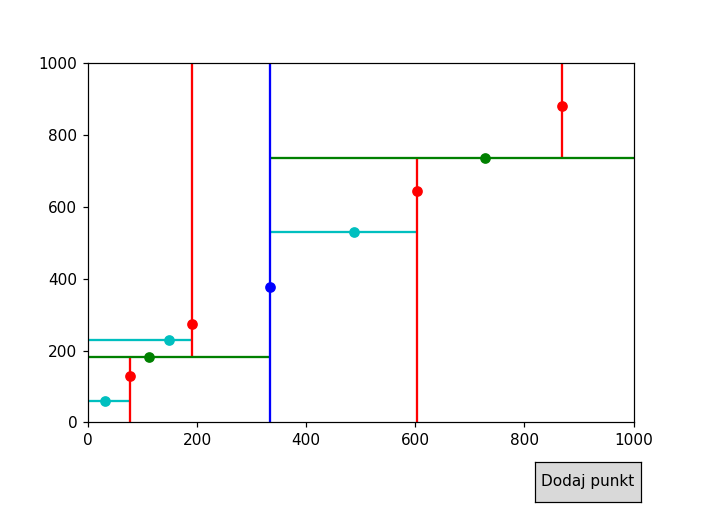

In [16]:
KD_tree = KD_Tree([Point(SCENE_X[0], SCENE_Y[0]), Point(SCENE_X[1], SCENE_Y[1])])
KD_tree.construct(get_points(plot_KD_2))
print("Tree height:",KD_tree.get_height())
plot_KD_2 = Plot([KD_tree.get_scene()])
plot_KD_2.draw([SCENE_X.as_tuple(), SCENE_Y.as_tuple()])

### Przeszukiwanie

Wyszukuje punkty należące do zadnaego zbioru, punkty generowane są losowo

Tree height: 16   Construction time:  1.6556148529052734   Search time:  0.033991098403930664


<IPython.core.display.Javascript object>


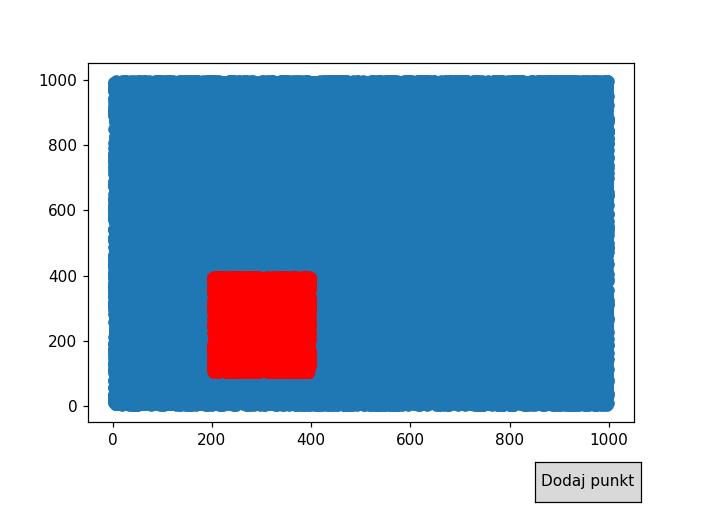

In [35]:
KD_random = KD_Tree([SCENE_X, SCENE_Y])
random_gen_points = gen_points(100000, SCENE_X[0], SCENE_X[1], SCENE_Y[0], SCENE_Y[1]) 
construct_time = KD_random.construct(random_gen_points)

kdtree_range_points, search_time = KD_random.find_in_boundary([Point(200,100),Point(400,400)])

plot_KD_random = Plot([Scene([points_to_PointsCollection(random_gen_points)
                        , points_to_PointsCollection(kdtree_range_points, color='r')])])

print("Tree height:", KD_random.get_height(), "  Construction time: ", construct_time, "  Search time: ", search_time)
plot_KD_random.draw()

# Quad-Tree

In [36]:
"""
X--------X--------X
|        |        |
|   0    |   1    |
|        |        |
X-----center------X
|        |        |
|   3    |   2    |
|        |        |
X--------X--------X
"""

def is_point_inside_rectangle(point, rec):
    return point.x >= rec[0].x and point.x <= rec[1].x and point.y >= rec[0].y and point.y <= rec[1].y

class QT_Node:
    def __init__(self, center, box_size):
        self.children = [QT_Leaf(), QT_Leaf(), QT_Leaf(), QT_Leaf()]
        self.center = center
        self.box_size = box_size
        
    def get_points_in_range(self, rectangle):
        points = []

        min_point = rectangle[0]
        max_point = rectangle[1]
        if(is_point_inside_rectangle(self.center, rectangle)):
            for child in self.children:
                points+=child.get_points_in_range(rectangle)
        else:
            # for 0
            rectangle_0 = [self.center+(-self.box_size,0), self.center+(0,self.box_size)]
            if(is_point_inside_rectangle(self.center+(-self.box_size,self.box_size), rectangle)
            or is_point_inside_rectangle(min_point, rectangle_0)
            or is_point_inside_rectangle(max_point, rectangle_0)):
                points+=self.children[0].get_points_in_range(rectangle)
                
            # for 1
            rectangle_1 = [self.center, self.center+(self.box_size,self.box_size)]
            if(is_point_inside_rectangle(self.center+(self.box_size,0), rectangle)
            or is_point_inside_rectangle(self.center+(0,self.box_size), rectangle) 
            or is_point_inside_rectangle(min_point, rectangle_1)):
                points+=self.children[1].get_points_in_range(rectangle)
                
            # for 2
            rectangle_2 = [self.center+(0,-self.box_size), self.center+(self.box_size,0)]
            if(is_point_inside_rectangle(self.center+(self.box_size,-self.box_size), rectangle)
            or is_point_inside_rectangle(min_point, rectangle_2)
            or is_point_inside_rectangle(max_point, rectangle_2)):
                points+=self.children[2].get_points_in_range(rectangle)
                
            # for 3
            rectangle_3 = [self.center+(-self.box_size,-self.box_size), self.center]
            if(is_point_inside_rectangle(self.center+(-self.box_size,0), rectangle)
            or is_point_inside_rectangle(self.center+(0,-self.box_size), rectangle)
            or is_point_inside_rectangle(max_point, rectangle_3)):
                points+= self.children[3].get_points_in_range(rectangle)
        
        return points
    
    def add_one(self, point):
        if(abs(point.x-self.center.x)>self.box_size or abs(point.y-self.center.y)>self.box_size): raise BaseException("error")
        node_id, node_center = self.find_node_for_point(point)
        
        if(isinstance(self.children[node_id], QT_Leaf) and not self.children[node_id].can_add_one()):
            node_point = self.children[node_id].point
            self.children[node_id] = QT_Node( node_center, self.box_size/2 )

            self.children[node_id].add_one(node_point)
            self.children[node_id].add_one(point)
        else:
            self.children[node_id].add_one(point)
            
    def find_node_for_point(self, point):
        if(point.x > self.center.x): # 1/ 2
            if(point.y > self.center.y):
                return 1, self.center + (self.box_size/2, self.box_size/2)
            else:
                return 2, self.center + (self.box_size/2, -self.box_size/2)
        else: # 0 / 3
            if(point.y > self.center.y):
                return 0, self.center + (-self.box_size/2, self.box_size/2)
            else:
                return 3, self.center + (-self.box_size/2, -self.box_size/2)
            
    def get_height(self):
            return 1+max([child.get_height() for child in self.children])
            
class QT_Leaf:
    def __init__(self):
        self.point = None
    
    def get_points_in_range(self, rectangle):
        if(self.point is not None and is_point_inside_rectangle(self.point, rectangle)):
            return [self.point]
        return []
    
    def can_add_one(self):
        return self.point is None
    
    def add_one(self, point):
        self.point = point
        
    def get_height(self):
        return 0
        

class QT_Tree:
    def __init__(self, minX=SCENE_X[0], maxX=SCENE_X[1], minY=SCENE_Y[0], maxY=SCENE_Y[1]):
        center = Point((minX+maxX)/2, (minY+maxY)/2)
        box_size = max( maxX-minX, maxY-minY ) / 2
        self.root = QT_Node(center, box_size)
        
    def get_points_in_range(self, min_point, max_point):
        time_start = time.time()
        rectangle = min_point, max_point
        points = self.root.get_points_in_range(rectangle)
        return points, time.time() - time_start
        
    def add_one(self, point):
        self.root.add_one(point)
        
        
    def add_multiple(self, points):
        time_start = time.time()
        for point in points:
            self.add_one(point)
        return time.time() - time_start
            
        
    def get_height(self):
        return self.root.get_height()
        
    def get_scene(self, points=None, lines=None, node=None, level=0):
        if(points==None): points = []
        if(lines==None): lines = []
        if(node==None): node=self.root
        
        level = level + 1
        if(level >= len(COLORS)): level = 0
            
        if(isinstance(node, QT_Leaf)):
            if(node.point is not None):
                points += [node.point]
        else:
            lines.append( LinesCollection([ 
                [ (node.center+(node.box_size, node.box_size)).as_tuple(), (node.center+(-node.box_size, node.box_size)).as_tuple() ]
                , [ (node.center+(-node.box_size, node.box_size)).as_tuple(), (node.center+(-node.box_size, -node.box_size)).as_tuple() ] 
                , [ (node.center+(-node.box_size, -node.box_size)).as_tuple(), (node.center+(node.box_size, -node.box_size)).as_tuple() ] 
                , [ (node.center+(node.box_size, -node.box_size)).as_tuple(), (node.center+(node.box_size, node.box_size)).as_tuple() ]  
                ], color = COLORS[level]) )
            lines.append( LinesCollection([ 
                 [ (node.center+(0, node.box_size)).as_tuple(), (node.center+(0, -node.box_size)).as_tuple() ] 
                , [ (node.center+(-node.box_size, 0)).as_tuple(), (node.center+(node.box_size, 0)).as_tuple() ]
                ], color = COLORS[level], linestyle = ':') )
            for child in node.children:
                self.get_scene(points, lines, child, level)

        return Scene([points_to_PointsCollection(points)], lines)
        

### Tworzenie

Uruchom komórkę, by zresetować zbiór punktów dla których budowane jest drzewo QT

In [30]:
plot_QT_2 = Plot([Scene()])

#Aby wygenerować punkty odkomentuj poniższą linijkę
#plot_QT_2 = Plot([Scene([PointsCollection(gen_points(10, SCENE_X[0], SCENE_X[1], SCENE_Y[0], SCENE_Y[1]))])])

Poniższa komórka tworzy drzewo dla aktywnego zbioru punktów QT, zresetuj ją by zbudować drzewo również dla nowo dodanych punktów

Tree height: 1


<IPython.core.display.Javascript object>


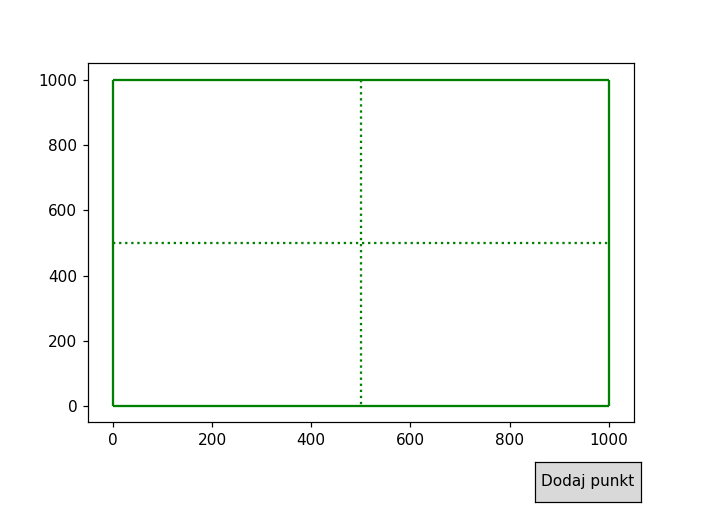

In [31]:
quad_tree = QT_Tree()
quad_tree.add_multiple(get_points(plot_QT_2))
scene = quad_tree.get_scene()
plot_QT_2 = Plot([scene])
print("Tree height:",quad_tree.get_height())
plot_QT_2.draw()

### Przeszukiwanie

Wyszukuje punkty należące do zadanego zbioru, wykorzystywane są punkty wygenerowanego wcześniej dla drzewa KD

Tree height: 17   Construction time:  3.4345040321350098   Search time:  0.02099323272705078


<IPython.core.display.Javascript object>


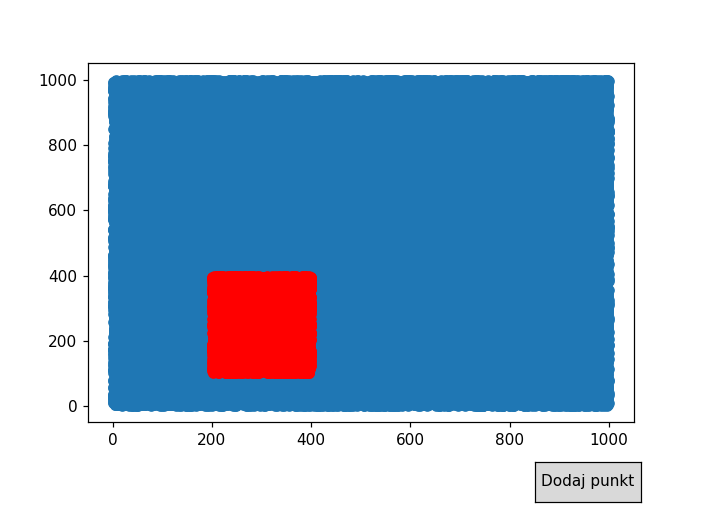

In [37]:
quad_tree_random = QT_Tree()
#random_gen_points = gen_points(100, SCENE_X[0], SCENE_X[1], SCENE_Y[0], SCENE_Y[1]) 
construct_time = quad_tree_random.add_multiple(random_gen_points)
quad_range_points, search_time = quad_tree_random.get_points_in_range(Point(200,100),Point(400,400))

plot_QT_random = Plot([Scene([points_to_PointsCollection(random_gen_points)
                        , points_to_PointsCollection(quad_range_points, color='r')])])

print("Tree height:",quad_tree_random.get_height(), "  Construction time: ", construct_time, "  Search time: ", search_time)
plot_QT_random.draw()

# Naiwne przeszukiwanie

In [13]:
start_time = time.time()
search_range = (Point(200,100),Point(400,400))
out = []
for point in random_gen_points:
    if(point.x >= search_range[0].x and point.x <= search_range[1].x and point.y >= search_range[0].y and point.y <= search_range[1].y):
        out.append(point)

print("Search time: ", time.time() - start_time)

Search time:  0.026056766510009766
